# Data

> #### Extended-representation bisulfite sequencing of gene regulatory elements in multiplexed samples and single cells
https://www.nature.com/articles/s41587-021-00910-x

Data: [GSE149954](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE149954)
- [HL60 Bisulfite-Seq - 10ng dmso](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4518676)
- [HL60 Bisulfite-Seq - 10ng decitabine](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4518677)

### methylKit

- https://github.com/al2na/methylKit
- https://bioconductor.org/packages/release/bioc/html/genomation.html
- https://www.slideshare.net/AlexanderGosdschan/eurobioc-2018-metyhlkit-overview

In [1]:
library(methylKit)
library(DSS)
library(tidyverse)
library(ggrepel)
library(patchwork)
library(genomation)
library(GenomicFeatures)
library(ORFik)
library(ggExtra)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain 

In [254]:
source('../scripts/util.R')

source('DNAme.R')

## gene/transcript/region level DNA-me scoring

### $$\textrm{DNA-me score} = \frac{\textrm{region CpG count} + 0.05}{\textrm{region size (bp)}}$$

<!-- \textrm{number of CG}} -->

In [498]:
normalizeByWidth <- function(me){
    
    width=me$end-me$start
    me$coverage=(me$coverage + 0.05)/width
    me$numCs=(me$numCs + 0.05)/width
    me$numTs=(me$numTs + 0.05)/width
    
    return(me)
}

prepRegion <- function(me){
    # Perform custom normalizeByWidth
    me[[1]] = me[[1]] %>% normalizeByWidth
    me[[2]] = me[[2]] %>% normalizeByWidth
    
    # Merge the samples again
    return(methylKit::unite(me, destrand=FALSE))
}

### Load DNA-me data


In [130]:
CpG_meth <- readRDS(file = "methylKit/meth.rds")

In [135]:
# CpG_meth

#### Filtering samples based on read coverage & Merging samples

In [13]:
CpG_meth_merged = prepRegion(CpG_meth)

uniting...



In [14]:
# # tileMethylCounts win.size=500 step.size=500
# CpG_tiles = readRDS('methylKit/CpG_tiles.rds')

In [16]:
# CpG_tiles %>% dim

### Prepare genome annotations 


In [248]:
# First load the annotation data; i.e the coordinates of promoters, TSS, intron and exons
gene.obj = readTranscriptFeatures("genes.bed.gz")

Reading the table...

Calculating intron coordinates...

Calculating exon coordinates...

Calculating TSS coordinates...

Calculating promoter coordinates...

Outputting the final GRangesList...




In [383]:
# Load the CpG info
cpg_anot <- readFeatureFlank("CpG_islands.bed.gz", feature.flank.name = c("CpGi", "shores"), flank=2000)

___

In [219]:
GTF = '~/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'
gtf <- rtracklayer::import(GTF)

In [220]:
gtf$type %>% levels

[1] "gene"           "transcript"     "exon"           "CDS"           
[5] "start_codon"    "stop_codon"     "UTR"            "Selenocysteine"

In [221]:
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% 
    column_to_rownames('gene_id') %>% 
    dplyr::select('gene_name')

In [222]:
tx2name <- gtf[gtf$type == "transcript"] %>% data.frame %>% 
    column_to_rownames('transcript_id') %>% 
    dplyr::select('gene_name','transcript_name')

___

https://support.bioconductor.org/p/124164/

In [8]:
txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')

In [9]:
txdb

TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: ~/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf
# Organism: Homo sapiens
# Taxonomy ID: 9606
# miRBase build ID: NA
# Genome: NA
# Nb of transcripts: 228048
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2022-10-11 01:25:53 -0700 (Tue, 11 Oct 2022)
# GenomicFeatures version at creation time: 1.46.1
# RSQLite version at creation time: 2.2.8
# DBSCHEMAVERSION: 1.2

In [46]:
# transcriptsBy(txdb, by=c("gene", "exon", "cds"), use.names=FALSE)
# exonsBy(x, by=c("tx", "gene"), use.names=FALSE)
# cdsBy(x, by=c("tx", "gene"), use.names=FALSE)
# intronsByTranscript(x, use.names=FALSE)
# fiveUTRsByTranscript(x, use.names=FALSE)
# threeUTRsByTranscript(x, use.names=FALSE)

### CpG promoters

In [232]:
# prmoters of all gene ids 
suppressWarnings(
    CpG_promoters <- regionCounts(CpG_meth, genes(txdb, columns="gene_id") %>% promoters %>% unique) %>% prepCounts
    )

uniting...



In [242]:
CpG_promoters_diff <- methylKit::calculateDiffMeth(CpG_promoters,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [256]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_promoters_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_promoters_diff$all,"GRanges"),feature = gene.obj
)

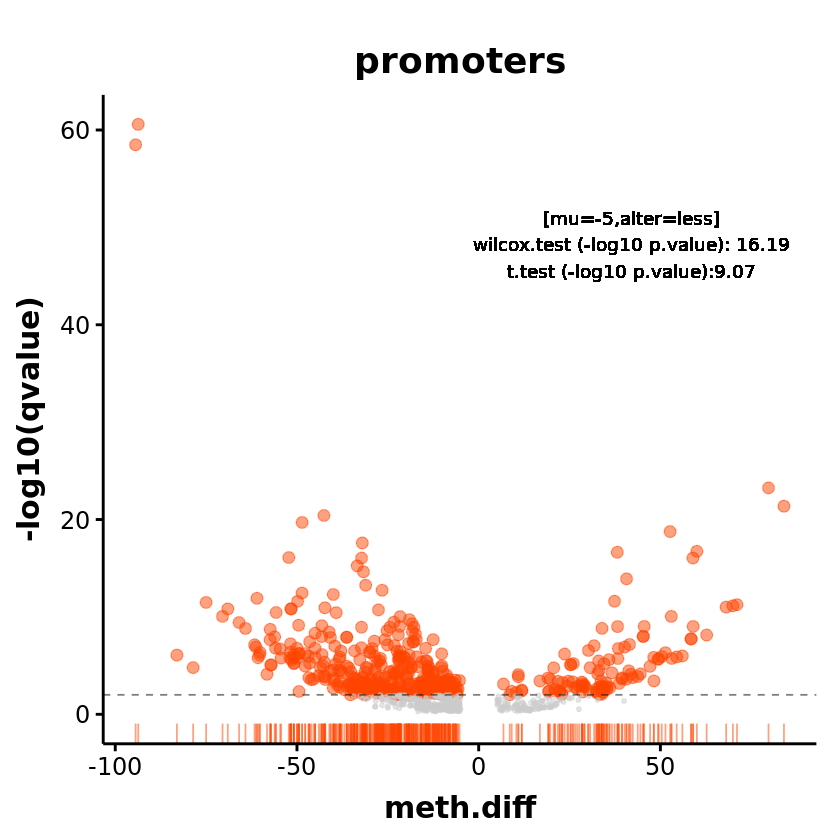

In [259]:
getPromoterDiff(CpG_promoters_diff$all,CpG_promoters_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.01, hypo_test = T, title = 'promoters')

In [266]:
# getPromoterDiff(CpG_promoters_diff$all,CpG_promoters_diff$all.anot)

### CpG islands

In [387]:
# prmoters of all gene ids 
suppressWarnings(
    CpG_islands <- regionCounts(CpG_meth, cpg_anot$CpGi %>% unique) %>% prepCounts
    )

uniting...



In [388]:
CpG_islands_diff <- methylKit::calculateDiffMeth(CpG_islands,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [389]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_islands_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_islands_diff$all,"GRanges"),feature = gene.obj
)

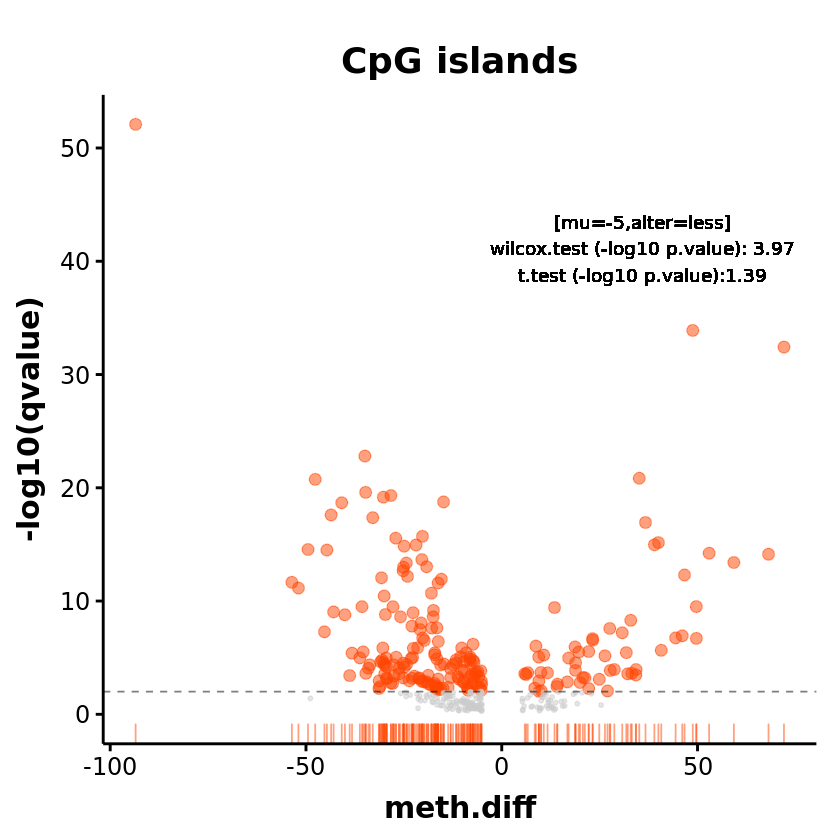

In [391]:
getPromoterDiff(CpG_islands_diff$all,CpG_islands_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.01, hypo_test = T, title = 'CpG islands')

In [392]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we 
# first coerce the methylKit object to GRanges.
CpG_islands_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_islands_diff$all,"GRanges"),feature = gene.obj)

[1] 479   7

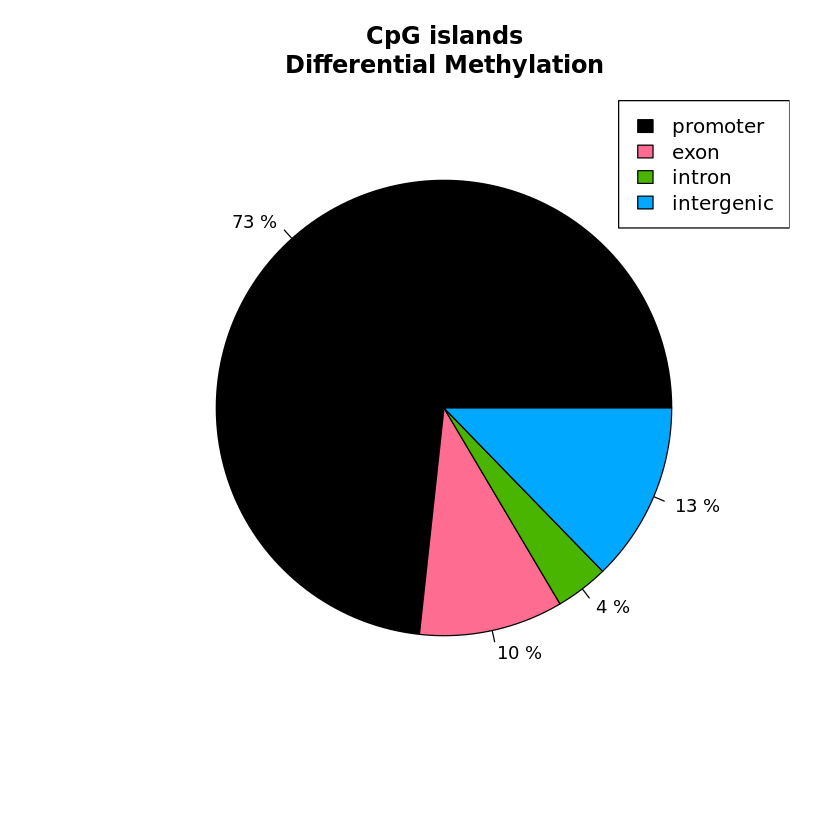

In [393]:
CpG_islands_diff$all %>% dim
# This can also be summarized for all differentially methylated CpGs
plotTargetAnnotation(CpG_islands_diff$all.anot, main = "CpG islands\nDifferential Methylation")

### CpG genes

In [464]:
# prmoters of all gene ids 
suppressWarnings(
    CpG_genes <- regionCounts(CpG_meth, genes(txdb, columns="gene_id") %>% unique) %>% prepCounts
    # prepRegion
    )

uniting...



In [480]:
CpG_genes_diff <- methylKit::calculateDiffMeth(CpG_genes,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 20, qvalue.thr = 0.05)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [481]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_genes_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_genes_diff$all,"GRanges"),feature = gene.obj
)

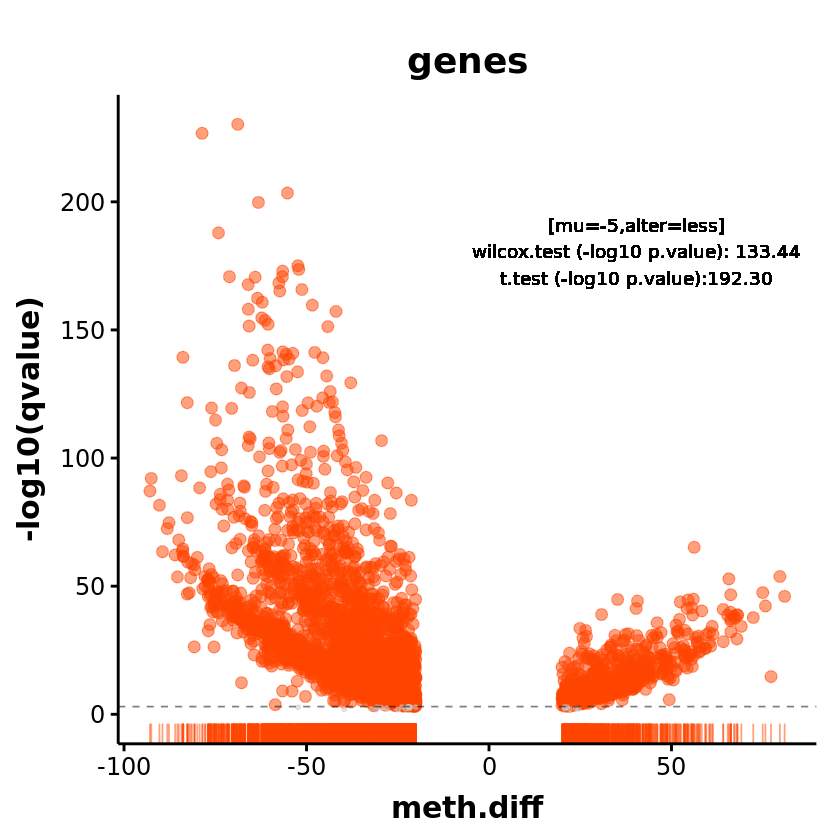

In [482]:
getPromoterDiff(CpG_genes_diff$all,CpG_genes_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(20,0.001, hypo_test = T, title = 'genes')

### CpG CDS

In [370]:
CDS = transcriptsBy(txdb, by=c("cds"), use.names=FALSE) %>% unlist %>% unique
names(CDS) = NULL

In [371]:
suppressWarnings(
    CpG_cds <- regionCounts(CpG_meth, CDS) %>% methylKit::unite(destrand=FALSE) 
    #%>% prepRegion
)

uniting...



In [373]:
CpG_cds_diff <- methylKit::calculateDiffMeth(CpG_cds,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [374]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_cds_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_cds_diff$all,"GRanges"),feature = gene.obj
)

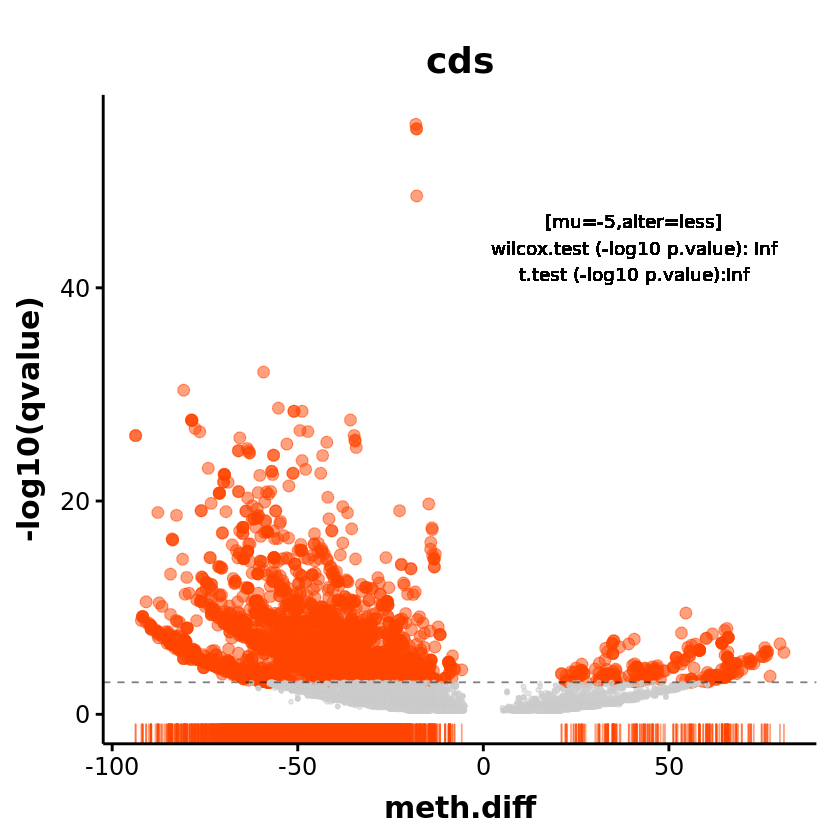

In [375]:
getPromoterDiff(CpG_cds_diff$all,CpG_cds_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.001, hypo_test = T, title = 'cds')

In [362]:
# getPromoterDiff(CpG_genes_diff$all,CpG_genes_diff$all.anot) %>% data.frame

### CpG exons

In [433]:
suppressWarnings(
    CpG_exons <- regionCounts(CpG_meth, exons(txdb) %>% unique) %>% prepCounts
    #%>% prepRegion
)

uniting...



In [437]:
CpG_exons_diff <- methylKit::calculateDiffMeth(CpG_exons,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [438]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_exons_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_exons_diff$all,"GRanges"),feature = gene.obj
)

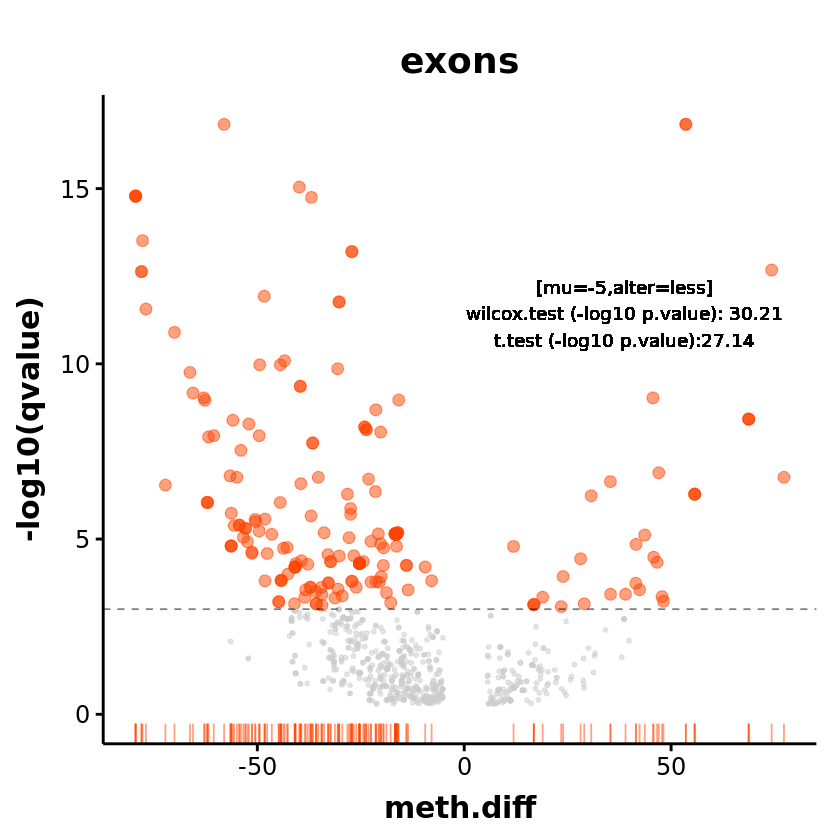

In [440]:
getPromoterDiff(CpG_exons_diff$all,CpG_exons_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.001, hypo_test = T, title = 'exons')

In [ ]:
# getPromoterDiff(CpG_genes_diff$all,CpG_genes_diff$all.anot) %>% data.frame

### CpG introns

In [401]:
introns = intronsByTranscript(txdb) %>% unlist %>% unique
names(introns) = NULL

In [404]:
suppressWarnings(
    CpG_introns <- regionCounts(CpG_meth, introns) %>% prepCounts
    #%>% prepRegion
)

uniting...



In [407]:
CpG_introns_diff <- methylKit::calculateDiffMeth(CpG_introns,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [409]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_introns_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_introns_diff$all,"GRanges"),feature = gene.obj
)

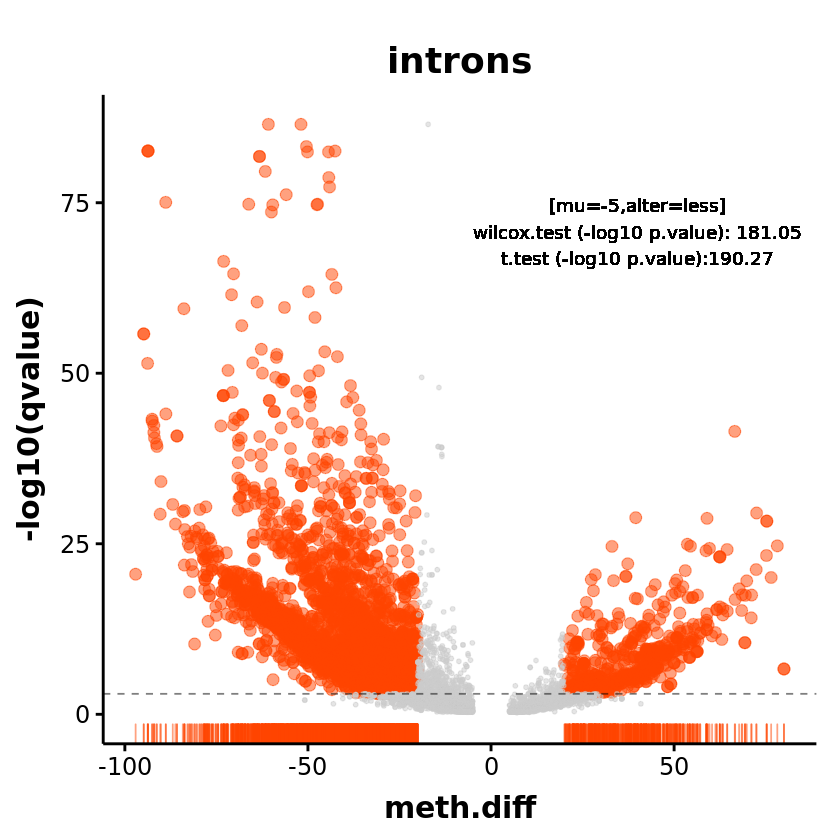

In [412]:
getPromoterDiff(CpG_introns_diff$all,CpG_introns_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(20,0.001, hypo_test = T, title = 'introns')

In [427]:
# getPromoterDiff(CpG_introns_diff$all,CpG_introns_diff$all.anot) %>% data.frame 
# %>% filter(feature.name %in% c(""))

### CpG fiveUTRs

In [326]:
fiveUTRs = fiveUTRsByTranscript(txdb) %>% unlist %>% unique
names(fiveUTRs) = NULL

In [327]:
suppressWarnings(
    CpG_fiveUTRs <- regionCounts(CpG_meth, fiveUTRs) %>% methylKit::unite(destrand=FALSE)
    #%>% prepRegion
)

uniting...



In [344]:
CpG_fiveUTRs_diff = methylKit::calculateDiffMeth(
    CpG_fiveUTRs,
    overdispersion = "MN",adjust="BH"
) %>% getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [345]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_fiveUTRs_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_fiveUTRs_diff$all,"GRanges"),feature = gene.obj
)

Warning message in wilcox.test.default(res$meth.diff, mu = -5, alternative = "less"):
“cannot compute exact p-value with ties”


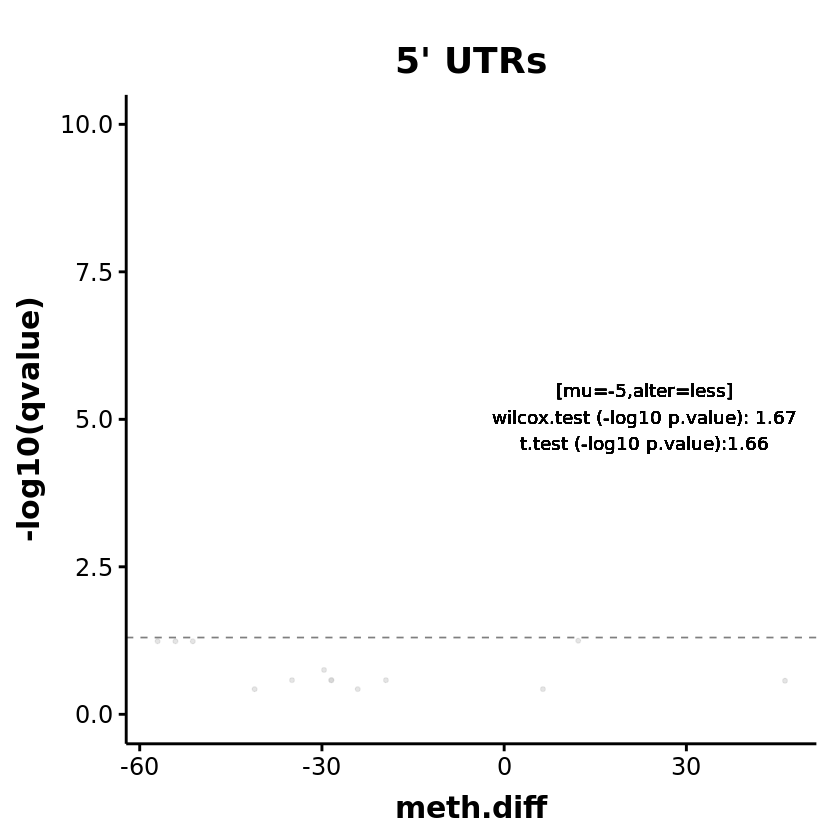

In [347]:
getPromoterDiff(CpG_fiveUTRs_diff$all,CpG_fiveUTRs_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.05, hypo_test = T, title = "5' UTRs",y_lim = 10)

### 

### Differentially DNAme tiles within RNAme peaks

In [445]:
RNAme_table = read.table('../meRIP-seq/radar/result.sig.txt',header=T) 

RNAme_exons = read.table('../meRIP-seq/radar/result.sig.bed') %>% genomation::bed12ToExons()
# RNAme_introns = read.table('../meRIP-seq/radar/result.sig.bed') %>% genomation::bed12ToIntrons()

In [491]:
as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")[
    as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")
    %over%
    as(CpG_genes_diff$hyper, "GRanges") 
] #%>% data.frame

GRanges object with 71 ranges and 11 metadata columns:
       seqnames              ranges strand |        name     score thickStart
          <Rle>           <IRanges>  <Rle> | <character> <integer>  <integer>
   [1]    chr13   77007624-77007673      - |       FBXL3         0   77007624
   [2]    chr17   28633963-28634012      - |    KIAA0100         0   28633963
   [3]    chr17   28634593-28634642      - |    KIAA0100         0   28634593
   [4]    chr17   28635491-28635540      - |    KIAA0100         0   28635491
   [5]     chr1 235131933-235135686      - |      ARID4B         0  235131933
   ...      ...                 ...    ... .         ...       ...        ...
  [67]    chr17   81930505-81930554      + |     MAFG-DT         0   81930505
  [68]     chr1 149190761-149191161      + |  AC245297.4         0  149190761
  [69]     chr7 130882506-130882555      - |  AC016831.6         0  130882506
  [70]     chr9   69221417-69221466      + |  AL358113.1         0   69221417
  [71]   

In [492]:
as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")[
    as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")
    %over%
    as(CpG_islands_diff$hypo, "GRanges") 
]

GRanges object with 5 ranges and 11 metadata columns:
      seqnames              ranges strand |        name     score thickStart
         <Rle>           <IRanges>  <Rle> | <character> <integer>  <integer>
  [1]     chr6 108561184-108561233      + |       FOXO3         0  108561184
  [2]     chr6 108561483-108561532      + |       FOXO3         0  108561483
  [3]     chr9 136439299-136439348      - |      INPP5E         0  136439299
  [4]    chr17   83085094-83085143      + |      METRNL         0   83085094
  [5]    chr22   23181534-23181583      + |         BCR         0   23181534
       thickEnd   itemRgb blockCount  blockSizes blockStarts     logFC
      <integer> <integer>  <integer> <character> <character> <numeric>
  [1] 108561233         0          1          49           0   4.30407
  [2] 108561532         0          1          49           0   5.15040
  [3] 136439348         0          1          49           0   4.10264
  [4]  83085143         0          1          49    

In [493]:
as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")[
    as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")
    %over%
    as(CpG_promoters_diff$hypo, "GRanges") 
]

GRanges object with 1 range and 11 metadata columns:
      seqnames        ranges strand |        name     score thickStart
         <Rle>     <IRanges>  <Rle> | <character> <integer>  <integer>
  [1]    chr11 207810-207859      + |       RIC8A         0     207810
       thickEnd   itemRgb blockCount  blockSizes blockStarts     logFC
      <integer> <integer>  <integer> <character> <character> <numeric>
  [1]    207859         0          1          49           0   5.80212
          p_value            ensembl
        <numeric>        <character>
  [1] 1.80381e-06 ENSG00000177963.14
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [494]:
as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")[
    as(RNAme_table %>% filter(abs(logFC) > 2), "GRanges")
    %over%
    as(CpG_introns_diff$hyper, "GRanges") 
]

GRanges object with 10 ranges and 11 metadata columns:
       seqnames              ranges strand |        name     score thickStart
          <Rle>           <IRanges>  <Rle> | <character> <integer>  <integer>
   [1]    chr10   75399999-75400048      - |      ZNF503         0   75399999
   [2]    chr10   75400246-75400295      - |      ZNF503         0   75400246
   [3]     chr8   42535258-42535307      - |     SLC20A2         0   42535258
   [4]    chr17   64896947-64896996      - |    LRRC37A3         0   64896947
   [5]     chr7   99487307-99487356      + |      ZNF789         0   99487307
   [6]     chr7 130882482-130882531      - |  AC016831.1         0  130882482
   [7]     chr1   81502089-81502138      + |    ARID3BP1         0   81502089
   [8]     chr4     3942310-3942359      - |     FAM86EP         0    3942310
   [9]     chr1 149190761-149191161      + |  AC245297.4         0  149190761
  [10]     chr7 130882506-130882555      - |  AC016831.6         0  130882506
        t

## $\Delta$RNA vs. DNA-me

In [ ]:
regionCounts

In [501]:
CpG_genes_norm_by_width <- regionCounts(CpG_meth, genes(txdb, columns="gene_id") %>% unique) %>% prepRegion

uniting...



In [506]:
CpG_genes_norm_by_width

,chr,start,end,strand,coverage1,numCs1,numTs1,coverage2,numCs2,numTs2
,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,586071,827796,-,0.003847554,0.0006869376,0.003160823,0.0003932154,2.068466e-07,3.932154e-04
2,chr1,629640,630683,+,0.407526366,0.0019654842,0.405608821,0.0911313519,4.793864e-05,9.113135e-02
3,chr1,944203,959309,-,0.038001456,0.0245630875,0.013441679,0.0006652986,2.681054e-04,4.005031e-04
4,chr1,975204,982093,-,0.112795761,0.0455871679,0.067215851,0.0058136159,2.975758e-04,5.523298e-03
5,chr1,1020120,1056118,+,0.060060281,0.0397535974,0.020308073,0.0005569754,3.902995e-04,1.680649e-04
6,chr1,1081818,1116361,-,0.036304027,0.0309483832,0.005357091,0.0012173233,8.988797e-04,3.198912e-04
7,chr1,1292390,1309609,-,0.084386434,0.0400168419,0.044372495,0.0005836576,4.675068e-04,1.190545e-04
8,chr1,1331280,1335314,+,0.101400595,0.0919806644,0.009432325,0.0029871096,2.739217e-03,2.602876e-04
9,chr1,1352689,1361777,-,0.088473812,0.0335662412,0.054913072,0.0011058539,5.501761e-06,1.105854e-03


In [374]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_cds_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_cds_diff$all,"GRanges"),feature = gene.obj
)

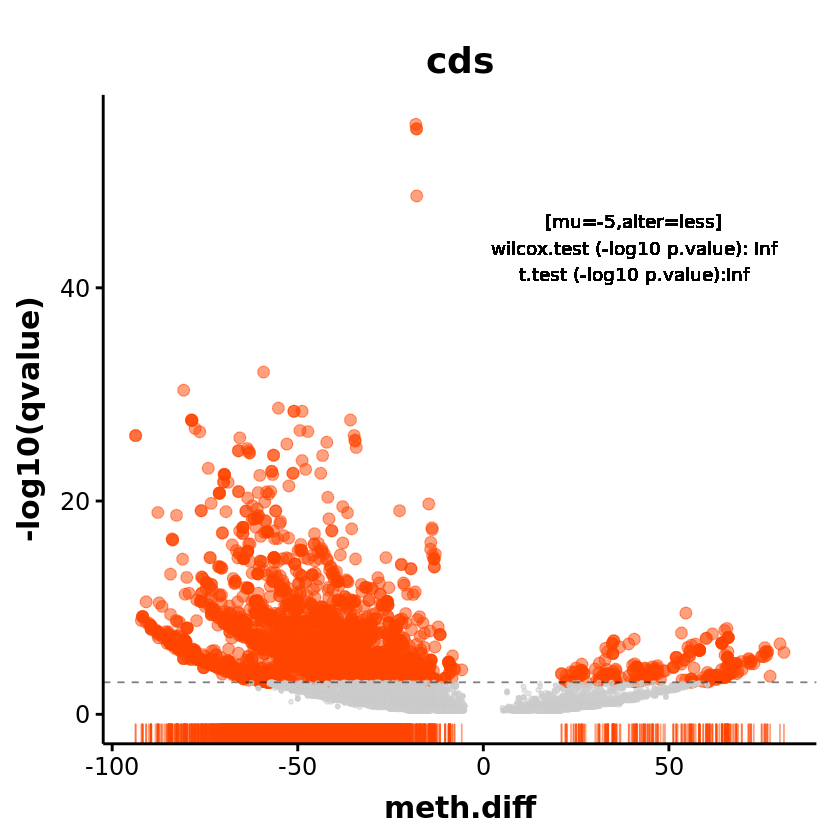

In [375]:
getPromoterDiff(CpG_cds_diff$all,CpG_cds_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.001, hypo_test = T, title = 'cds')

In [503]:
CpG_genes_norm_by_width@treatment

[1] 0 1

In [504]:
CpG_genes_norm_by_width@sample.ids

[1] "DMSO"       "Decitabine"

In [ ]:
# as(CpG_meth_merged,"GRanges")
transcriptsBy(txdb, by=c("gene", "exon", "cds"), use.names=FALSE)[
    transcriptsBy(txdb, by=c("gene", "exon", "cds"), use.names=FALSE)
    %over% 
    as(CpG_meth_merged,"GRanges") 
]

### Differentially DNAme tiles within exons/introns peaks

In [373]:
suppressWarnings(
    CpG_exons <- regionCounts(CpG_meth, exons %>% unique) %>% prepRegion
)
suppressWarnings(
    CpG_introns <- regionCounts(CpG_meth, introns %>% unique) %>% prepRegion
)

uniting...

uniting...



In [374]:
CpG_exons_diff <- calculateDiffMeth(CpG_exons,
                            overdispersion = "MN",
                            adjust="BH") %>% getDiffList


CpG_introns_diff <- calculateDiffMeth(CpG_introns,
                            overdispersion = "MN",
                            adjust="BH") %>% getDiffList

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


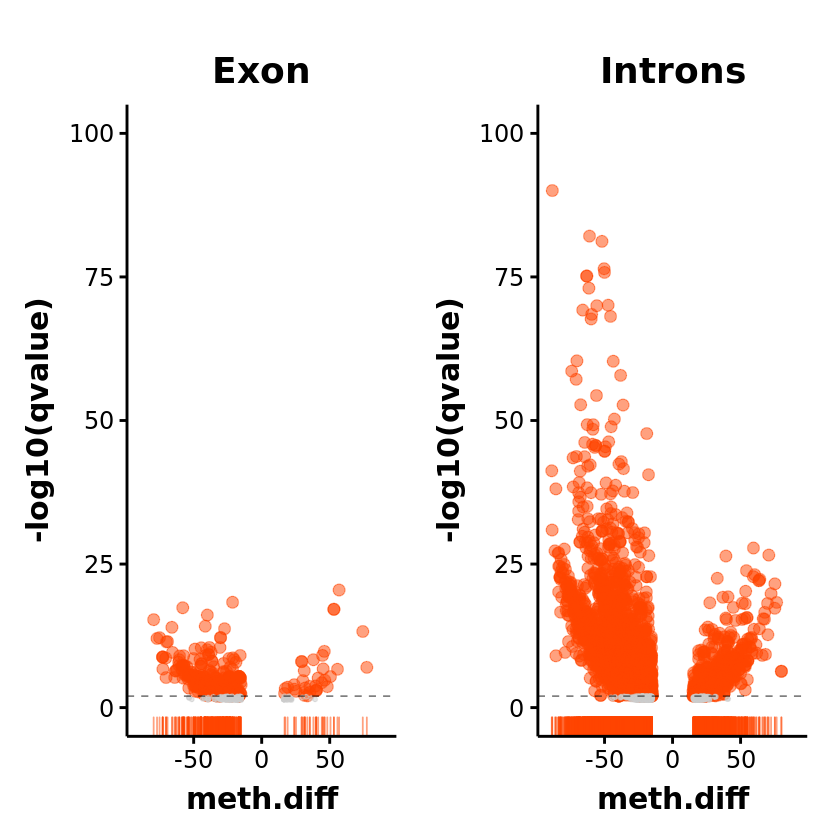

In [375]:
CpG_exons_diff$all %>% data.frame %>% 
    plot_hyperhypo(5,0.01,title="Exon",x_lim=c(-90,90),y_lim = 100) + 

CpG_introns_diff$all %>% data.frame %>% 
    plot_hyperhypo(5,0.01,title="Introns",x_lim=c(-90,90),y_lim = 100)

#### hyper DNAme in both exon and intron!

In [376]:
intersect(
    tx2name[exons[exons %over% as(CpG_exons_diff$hyper,'GRanges')]$name,]$gene_name %>% unique,
    tx2name[introns[introns %over% as(CpG_introns_diff$hyper,'GRanges')]$name,]$gene_name %>% unique 
)

[1] "AC093909.4" "SMOC2"      "CD72"       "COL13A1"    "AC063960.2"
[6] "KANK3"

#### hypo DNAme in both exon and intron!

In [377]:
intersect(
    tx2name[exons[exons %over% as(CpG_exons_diff$hypo,'GRanges')]$name,]$gene_name %>% unique,
    tx2name[introns[introns %over% as(CpG_introns_diff$hypo,'GRanges')]$name,]$gene_name %>% unique 
)

[1] "KAZN"        "EPHA10"      "CDK11A"      "AL031282.2"  "INTS3"      
  [6] "GALNT2"      "KCNAB2"      "NBPF1"       "PTPRF"       "SLC1A7"     
 [11] "TPM3"        "LRRN2"       "ALK"         "ERCC3"       "LIMS2"      
 [16] "VWC2L"       "CMPK2"       "LINC01238"   "MGLL"        "SRGAP3"     
 [21] "WNT7A"       "DLEC1"       "TIMMDC1"     "BPESC1"      "ESR1"       
 [26] "GMDS-DT"     "SLC22A23"    "AGPAT4"      "DUSP22"      "AL662899.4" 
 [31] "LY6G5B"      "GALNT17"     "PDE1C"       "NPC1L1"      "SLC26A4-AS1"
 [36] "AGAP3"       "PCAT1"       "CASC19"      "CASC11"      "FBXO10"     
 [41] "SH3PXD2A"    "TBC1D12"     "SLIT1"       "MACROH2A2"   "DUSP13"     
 [46] "ARAP1"       "RAB30-DT"    "ZBTB44"      "AP003559.1"  "SYT12"      
 [51] "ARHGEF17"    "SCN3B"       "CCDC60"      "NR4A1"       "RASA3"      
 [56] "SLC7A1"      "NIN"         "UNC79"       "EXOC3L4"     "PDPR"       
 [61] "ZNF263"      "PPL"         "AC016597.2"  "DERPC"       "CHTF8"      
 [66] "TANC2"       "STARD3"      "TEN1"        "TEN1-CDK3"   "PTPRM"      
 [71] "MYOM1"       "ZBTB7C"      "DCC"         "LINC00683"   "PIEZO2"     
 [76] "LAMA3"       "DTNA"        "LOXHD1"      "MYO5B"       "NEDD4L"     
 [81] "NFATC1"      "TGIF1"       "RALBP1"      "AC091151.2"  "ST8SIA5"    
 [86] "ADNP2"       "NFIC"        "SPINT2"      "ARHGAP35"    "MIER2"      
 [91] "TCF3"        "LYPD4"       "A1BG-AS1"    "ZNF446"      "ADARB1"     
 [96] "URB1"        "KIAA1671"    "TXNRD2"      "AL022238.4"  "LRP5L"      
[101] "CYTH4"

### Differentially methylated enhancers

In [ ]:
# SupEnh = read.csv('SE_02_1028_SE_hg38.bed',sep='\t',header=T) %>% GRanges

# SupEnh_ol <- findOverlaps(
#     SupEnh,
#     myDiffList_tiles$all %>% GRanges
# )

# myDiff_tiles_ann_gr = myDiffList_tiles$all %>% GRanges

In [ ]:
CpG_enh_diff <- CpG_tiles_diff_list$all.gr[CpG_tiles_diff_list$all.gr %over% enh$enhancer] %>% data.frame

In [ ]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we 
# first coerce the methylKit object to GRanges.
CpG_enh_diff.anot <- annotateWithGeneParts(
    target = as(CpG_enh_diff,"GRanges"),feature = gene.obj)

[1] 83  8

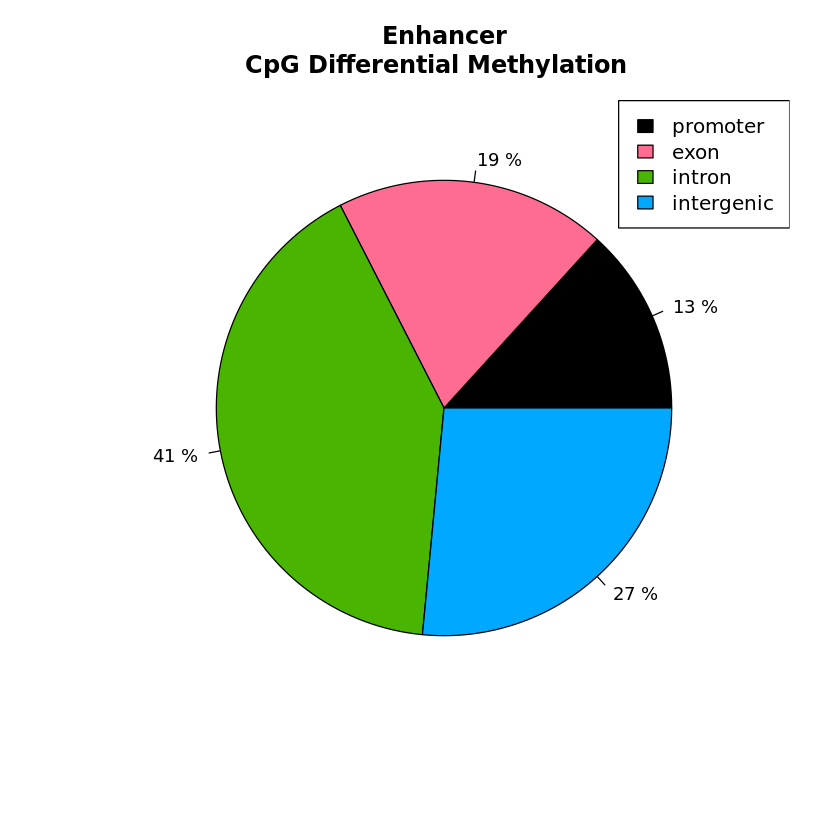

In [ ]:
CpG_enh_diff %>% dim
# This can also be summarized for all differentially methylated CpGs
plotTargetAnnotation(CpG_enh_diff.anot, main = "Enhancer\nCpG Differential Methylation  ")

___

## Volcano plots!

In [637]:
p1 <- CpGi_meth_diff %>% data.frame %>% 
plot_hyperhypo(5,0.01,title="CpGi",
               x_lim = c(-90,90),y_lim = 18) + 
    theme(
        #axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank()
    )

p2 = CpG_tiles_diff_list$all[df$exon > 0 & df $prom == 0,] %>% data.frame %>% 
plot_hyperhypo(5,0.01,title="Exon",x_lim=c(-90,90),y_lim = 18) + 
    theme(
        #axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        # axis.text.x = element_blank(),
        axis.title.x = element_blank()
    )


p3 = CpG_tiles_diff_list$all[df$intron > 0 & df$exon == 0& df $prom == 0,] %>% data.frame %>% 
plot_hyperhypo(5,0.01,title="Introns",x_lim=c(-90,90),y_lim = 18)+ 
    theme(
        axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        # axis.text.x = element_blank(),
        axis.title.x = element_blank()
    )

p4 = CpG_enh_diff %>% data.frame %>% 
plot_hyperhypo(5,0.01,title="Enhancers",x_lim = c(-90,90),y_lim=18)+ 
    theme(
        axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank()
    )

p = (p1+p4)/(p2+p3)

Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”


Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


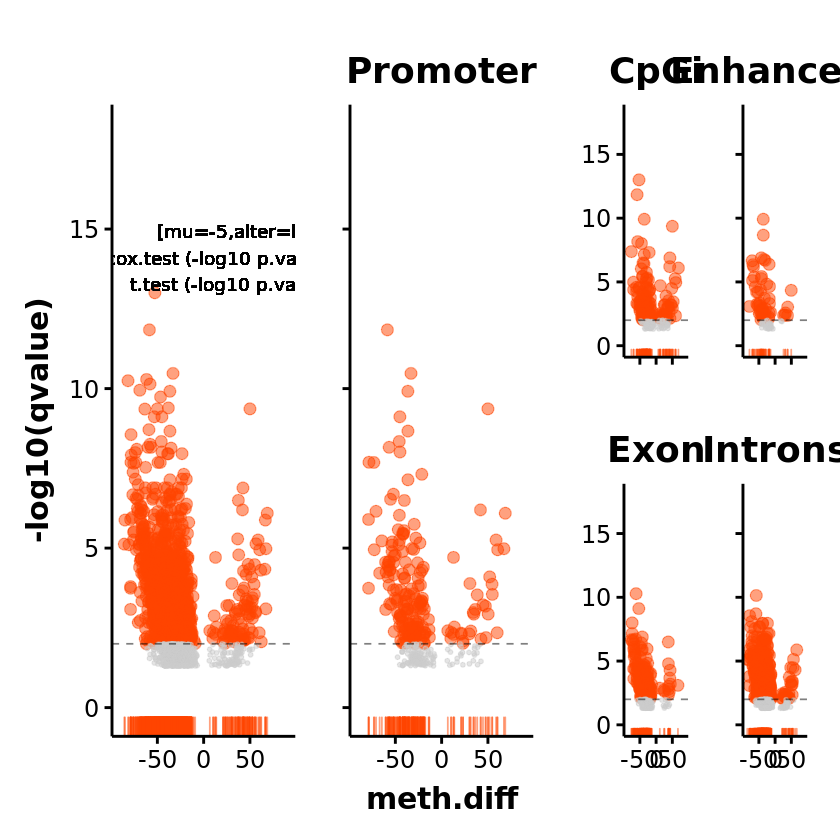

In [638]:
CpG_tiles_diff_list$all %>% data.frame %>% 
plot_hyperhypo(5,0.01,title="",x_lim = c(-90,90),y_lim = 18,hypo_test = T) + 
    theme(
        # axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.x = element_blank() 
    )+ 

CpG_tiles_diff_list$all[df$prom > 0,] %>% data.frame %>% 
    plot_hyperhypo(5,0.01,title="Promoter",x_lim=c(-90,90),y_lim = 18) + 
    theme(
        axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank() 
    )+ 

p

In [639]:
ggsave('plots/diff-DNAme-volcano.pdf',width=13,height=7)

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


___

#### RNA methylation genes

In [640]:
# RNAme_hyper_df = read.csv('../combined_analysis/mtyl-enrichment/hyper_mtyl.txt',sep='\t',header=F)
# RNAme_hyper = RNAme_hyper_df[,1] %>% unique
RNAme_hyper = RNAme_table %>% filter(logFC>4) %>% dplyr::select(name) %>% as.list %>% unique %>% unlist

In [641]:
# RNAme_hypo_df = read.csv('../combined_analysis/mtyl-enrichment/hypo_mtyl.txt',sep='\t',header=F)
# RNAme_hypo = RNAme_hypo_df[,1] %>% unique
RNAme_hypo = RNAme_table %>% filter(logFC< -4) %>% dplyr::select(name) %>% as.list %>% unique %>% unlist

Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


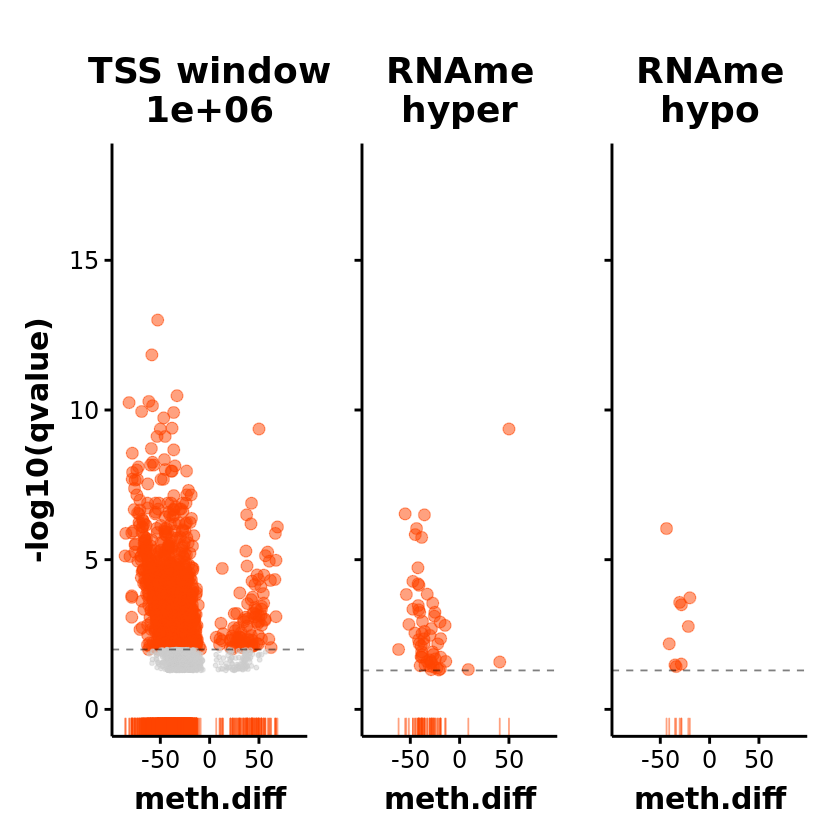

In [652]:
tss.window = 10**6

getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% plot_hyperhypo(5,0.01,title=paste0("TSS window\n",tss.window),x_lim=c(-90,90),y_lim = 18) + 
getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% filter(feature.name %in% RNAme_hyper) %>%
plot_hyperhypo(5,0.05,title="RNAme\nhyper",x_lim=c(-90,90),y_lim = 18) + 
    theme(
        axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank() 
    ) + 

getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% filter(feature.name %in% RNAme_hypo) %>%
plot_hyperhypo(5,0.05,title="RNAme\nhypo",x_lim=c(-90,90),y_lim = 18) + 
    theme(
        axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank() 
    )

RNAme_hyper

In [653]:
getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% filter(feature.name %in% RNAme_hyper) 

chr,start,end,strand,pvalue,qvalue,meth.diff,dist.to.feature,feature.name,feature.strand
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
chr16,30609501,30610000,*,4.354727e-13,4.316272e-10,50.024217,390,ZNF689,-
chr22,25362501,25363000,*,1.658785e-09,2.948868e-07,-55.238727,0,LRP5L,-
chr19,4809501,4810000,*,1.872525e-09,3.184107e-07,-35.714286,7971,TICAM1,-
chr17,46501501,46502000,*,7.158538e-09,9.129470e-07,-43.673090,-9511,LRRC37A2,+
chr16,22317001,22317500,*,1.325677e-08,1.453661e-06,-44.973211,19570,POLR3E,+
chr18,23187001,23187500,*,1.753413e-08,1.804631e-06,-38.500000,31178,CABLES1,+
chr7,43705001,43705500,*,3.464444e-07,1.864602e-05,-42.273442,23990,COA1,-
chr19,1634501,1635000,*,1.445603e-06,5.300392e-05,-47.368421,15288,TCF3,-
chr19,11945501,11946000,*,1.916223e-06,6.423725e-05,-42.105263,-754,ZNF700,+


RNAme_hypo

In [644]:
# getPromoterDiff(
#     CpG_tiles_diff_list$all, 
#     CpG_tiles_diff_list$all.anot, 
#     tss.window
# ) %>% filter(feature.name %in% RNAme_hypo) 

#### CRISPRi hits

In [548]:
sensitivity = c(
"AMBRA1","APCS","API5","ARGLU1","ARHGAP30","ARID4A","ARIH1","ATF7IP","BCL2","BLM","BRMS1","C16orf82","C6orf57",
    "CCAR1","CCDC125","CCDC22","CCDC53","CENPB","CHRM5","CHTOP","CIB4","CMTR2","COL4A5","COMMD1","COMMD2","COMMD4",
    "CP","CSDE1","CSNK1A1","CSNK2A1","CTDSPL2","CTPS1","CXXC4","CYLD","DCP2","DDA1","DDX17","DEF6","DEFB125","DET1",
    "DNAJA2","DYNLRB1","EIF3M","ERCC2","FAF2","FAM58A","FIBP","FZR1","GPATCH8","GPR162","GRB10","HNRNPM","ILF3","INO80E",
    "INTS5","KDM1A","KIAA0195","KIAA0196","LHFPL5","LSM14A","MARK3","MED23","METTL9","MON2","MSN","MTF1","NANS","NOP58",
    "NPRL3","PCBP1","PPP2R1A","PPP6C","PRKRIR","PTEN","PTPN7","PUM1","RAB5C","RABEP1","RALGAPB","RASA2","RASA3","RBBP4",
    "RBM14","RBM14-RBM4","RBM5","REG3G","RFC1","RGS19","RHOA","RNF4","SAMD1","SAP130","SCAF1","SCAF8","SDHAF1","SERF2",
    "SFPQ","SIN3A","SNRPB2","SOCS5","SQLE","SS18","SUPT20H","SYVN1","TAF6L","TBC1D22B","TBRG1","TCERG1","TFRC","TONSL",
    "TOP1","TPTE2","TRIB1","TTC39C","USP22","YTHDC1","ZC3H12D","ZC3H18","ZMYM2"
)

resistance = c(
    "ABHD17A","ACACA","ADAP1","ALG13","ALKBH8","ARL1","ARL2","ATP6V1E2","BCLAF1","BLOC1S3","BRAF","BRD8",
    "C14orf166","C14orf2","C16orf59","CARM1","CBLL1","CCDC134","CCDC6","CCNH","CDK2","CDK7","CENPF","CERS2",
    "CHORDC1","CPD","CSRP2BP","DCK","DCTD","DENR","DHX36","DMAP1","DPF2","EEF1E1","EIF5","ELL","ELP3","ELP5",
    "EP400","EPC1","EPC2","FAM122A","G3BP1","GIT2","GLS","HAUS1","HEATR6","HSD17B12","HSP90B1","HYOU1","IPO13",
    "KIAA1429","KIAA1731","KTI12","LARS2","MAP2K2","MARS","MEAF6","METTL3","MKI67","MRGBP","MRPL34","MRPL41","MRPS17",
    "NCK1","NR2C2AP","PDCL","PET117","PHF20","PITRM1","POLR1D","POLR3B","POLR3F","PPP1R18","PPP1R2","PREX1","PRMT7",
    "PTPLB","RAB3GAP2","RAC2","RANBP3","RAP1GDS1","RHOQ","RNFT1","SHOC2","SLC25A1","SMARCAD1","SNRNP40","SNX15","SRSF11"
    ,"TBCA","TELO2","THAP11","TRPM7","TTI2","VARS2","VPS29","VPS51","VPS54","VWA1","YARS2","YTHDF2","ZC3H13","ZCRB1"

)

Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


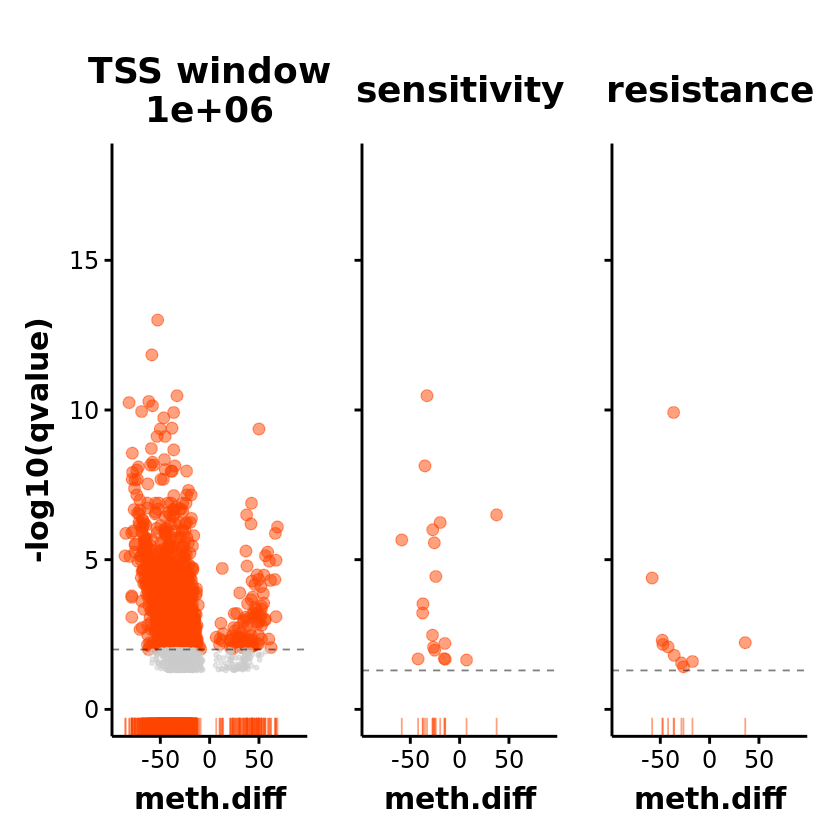

In [648]:
tss.window = 10**6

getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% plot_hyperhypo(5,0.01,title=paste0("TSS window\n",tss.window),x_lim=c(-90,90),y_lim = 18) + 
getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% filter(feature.name %in% sensitivity) %>%
plot_hyperhypo(5,0.05,title="sensitivity",x_lim=c(-90,90),y_lim = 18) + 
    theme(
        axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank() 
    ) + 

getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% filter(feature.name %in% resistance) %>%
plot_hyperhypo(5,0.05,title="resistance",x_lim=c(-90,90),y_lim = 18) + 
    theme(
        axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.y = element_blank() 
    ) 

sensitivity

In [649]:
getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% filter(feature.name %in% sensitivity) 

chr,start,end,strand,pvalue,qvalue,meth.diff,dist.to.feature,feature.name,feature.strand
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
chr8,125433501,125434000,*,8.527765e-15,3.335209e-11,-33.096873,0,TRIB1,+
chr8,125415001,125415500,*,1.442448e-11,7.358368e-09,-35.155844,-14858,TRIB1,+
chr16,46929501,46930000,*,1.859204e-09,3.184107e-07,37.500000,43675,DNAJA2,-
chr8,125447001,125447500,*,3.758801e-09,5.727534e-07,-19.720983,13457,TRIB1,+
chr8,125413001,125413500,*,7.995978e-09,9.980512e-07,-27.261720,-16858,TRIB1,+
chr8,125415501,125416000,*,2.198906e-08,2.193703e-06,-58.666667,-14358,TRIB1,+
chr8,125405001,125405500,*,2.887804e-08,2.732468e-06,-25.660399,-24858,TRIB1,+
chr8,125439001,125439500,*,8.797874e-07,3.647543e-05,-24.122635,5457,TRIB1,+
chr18,63310001,63310500,*,1.351844e-05,2.981425e-04,-37.183099,8313,BCL2,-


resistance

In [651]:
getPromoterDiff(
    CpG_tiles_diff_list$all, 
    CpG_tiles_diff_list$all.anot, 
    tss.window
) %>% filter(feature.name %in% resistance) 

chr,start,end,strand,pvalue,qvalue,meth.diff,dist.to.feature,feature.name,feature.strand
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
chr1,150975001,150975500,*,8.268787e-14,1.212721e-10,-36.48649,0,CERS2,-
chr19,18469001,18469500,*,1.016905e-06,4.086076e-05,-58.25397,6434,ELL,-
chr19,18513001,18513500,*,4.988090e-04,4.897511e-03,-48.00000,8571,ELL,-
chr11,107564001,107564500,*,6.388793e-04,5.916314e-03,36.17021,1019,ALKBH8,-
chr19,10898501,10899000,*,7.583555e-04,6.787021e-03,-47.36842,26800,CARM1,+
chr3,45406501,45407000,*,9.828010e-04,8.178159e-03,-42.10526,17667,LARS2,+
chr1,43964501,43965000,*,2.308190e-03,1.563626e-02,-35.89744,-939,IPO13,+
chr19,4121001,4121500,*,4.373304e-03,2.521473e-02,-17.39130,2618,MAP2K2,-
chr2,148597501,148598000,*,5.053656e-03,2.817259e-02,-28.57143,-46751,EPC2,+


# CHG context

In [746]:
# CHG_meth = methylKit::processBismarkAln(
#     files,
#     sample.id=list('DMSO',"Decitabine"),
#     assembly="hg38",
#     save.folder='methylKit',
#     save.context=NULL,
#     read.context="CHG",
#     nolap=FALSE,mincov=10,minqual=20,phred64=FALSE,
#     treatment=c(0,1)
# )

Trying to process:
	bismark//SRR11711272_1_val_1_bismark_bt2_pe.srt.bam
Using htslib.
Conversion Statistics:

total otherC considered (>95% C+T): 5762606
average conversion rate = 99.047786807278
total otherC considered (Forward) (>95% C+T): 2884165
average conversion rate (Forward) = 99.047276146
total otherC considered (Reverse) (>95% C+T): 2878441
average conversion rate (Reverse) = 99.048298484045

Done.

Reading methylation percentage per base for sample: DMSO 



Received single location.

Reading file.



Trying to process:
	bismark//SRR11711273_1_val_1_bismark_bt2_pe.srt.bam
Using htslib.
Conversion Statistics:

total otherC considered (>95% C+T): 106734
average conversion rate = 99.029191485374
total otherC considered (Forward) (>95% C+T): 53436
average conversion rate (Forward) = 99.033786269759
total otherC considered (Reverse) (>95% C+T): 53298
average conversion rate (Reverse) = 99.024584804103

Done.

Reading methylation percentage per base for sample: Decitabine 



Received single location.

Reading file.



In [747]:
# saveRDS(CHG_meth, file = "methylKit/CHG_meth.rds")

In [39]:
CHG_meth <- readRDS(file = "methylKit/meth_CHG.rds")

### Differentially methylated tiles

#### tileMethylCounts

In [40]:
CHG_tiles = tileMethylCounts(CHG_meth,win.size=500,step.size=500,cov.bases=0)

In [346]:
message("DMSO")
CHG_tiles[[1]]%>% dim
message("DAC")
CHG_tiles[[2]]%>% dim

DMSO



[1] 574113      7

DAC



[1] 16094     7

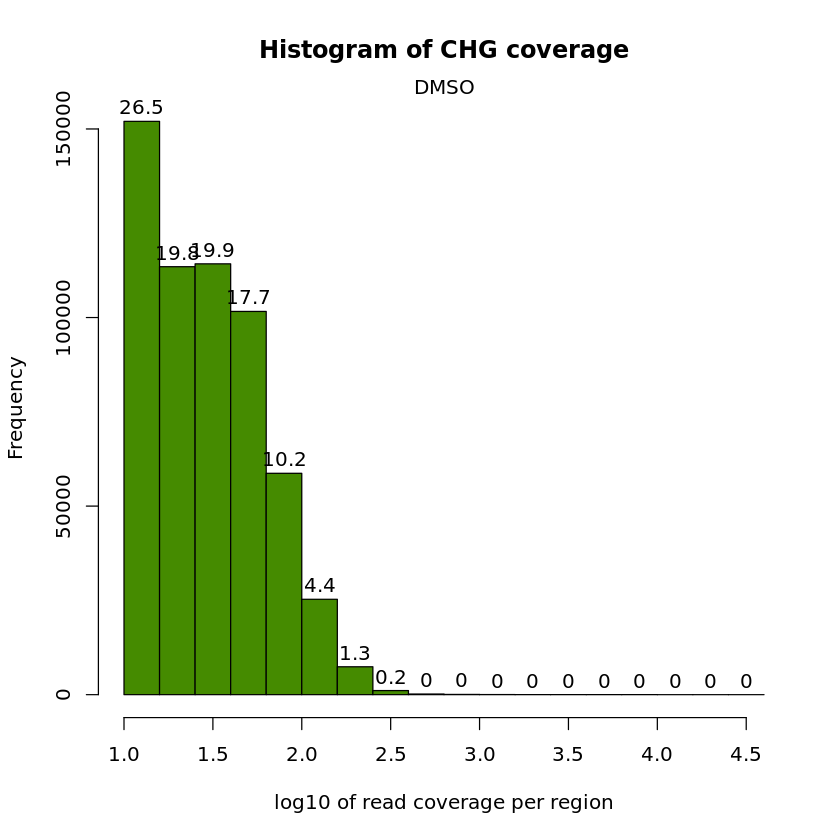

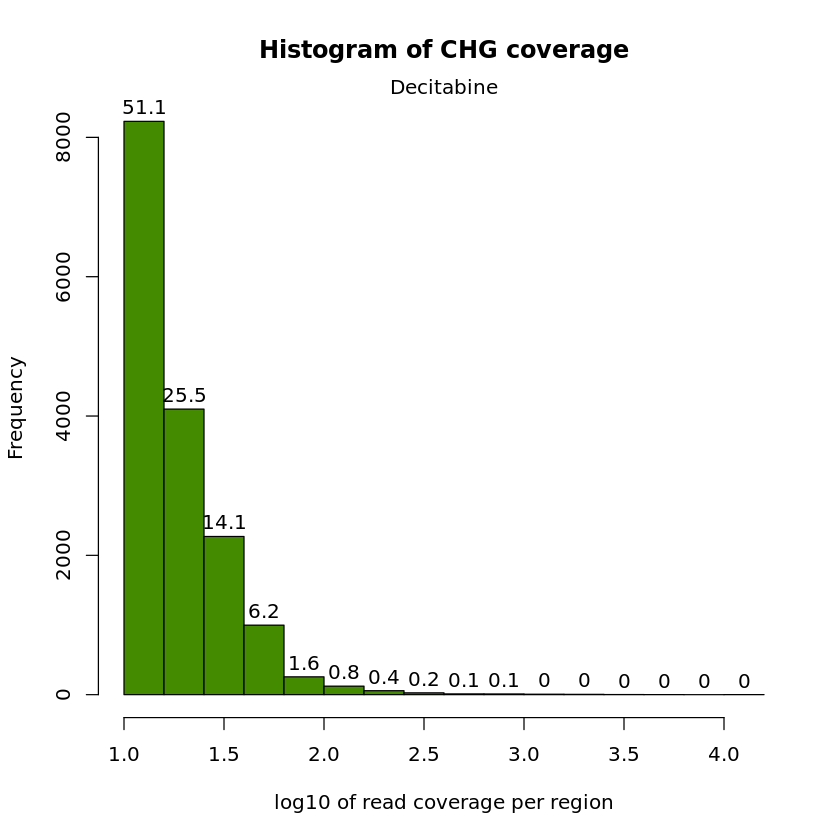

In [359]:
getCoverageStats(CHG_tiles[[1]],plot=TRUE) 
getCoverageStats(CHG_tiles[[2]],plot=TRUE)

In [42]:
CHG_tiles_merged = prepRegion(CHG_tiles)

uniting...



In [347]:
CHG_tiles_merged %>% dim

[1] 15059    10

#### calculateDiffMeth

In [44]:
CHG_tiles_diff <- calculateDiffMeth(CHG_tiles_merged,
                            overdispersion = "MN",
                            adjust="BH")

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [45]:
CHG_tiles_diff_list = getDiffList(CHG_tiles_diff)

Warning message in max(i):
“no non-missing arguments to max; returning -Inf”
Warning message in max(i):
“no non-missing arguments to max; returning -Inf”


In [46]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CHG_tiles_diff_list$all.anot <- annotateWithGeneParts(
    target = as(CHG_tiles_diff_list$all,"GRanges"),feature = gene.obj)

[1] 17  7

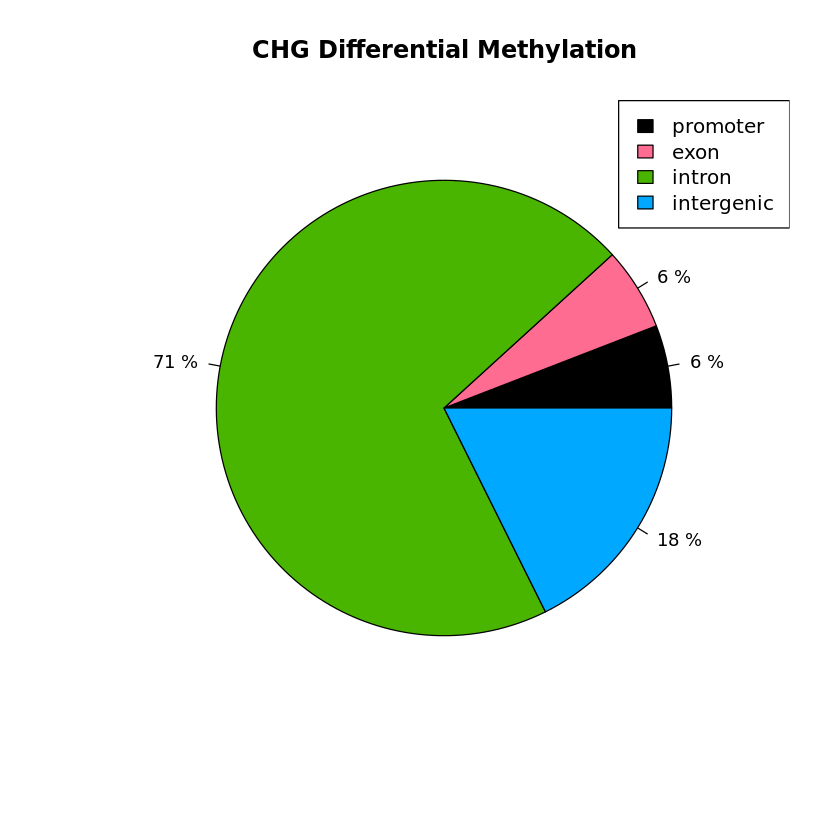

In [139]:
CHG_tiles_diff_list$all %>% dim
# This can also be summarized for all differentially methylated
plotTargetAnnotation(CHG_tiles_diff_list$all.anot, main = "CHG Differential Methylation")

In [345]:
getPromoterDiff(
    CHG_tiles_diff_list$all,
    CHG_tiles_diff_list$all.anot, 
    tss.window = 10**6
)

chr,start,end,strand,pvalue,qvalue,meth.diff,dist.to.feature,feature.name,feature.strand
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
chr18,79429001,79429500,*,6.403600e-13,9.643182e-09,56.51623,8167,AC018445.3,+
chr7,19399001,19399500,*,1.351947e-09,1.017949e-05,72.85714,45469,AC007091.1,+
chr1,11561001,11561500,*,1.489745e-08,7.478026e-05,51.89991,27327,DISP3,+
chr1,93622001,93622500,*,7.976780e-08,2.002039e-04,45.53571,-7905,BCAR3,-
chr18,79436501,79437000,*,6.363415e-08,2.002039e-04,18.03279,15667,AC018445.3,+
chr19,5987501,5988000,*,6.840929e-08,2.002039e-04,40.00000,9100,AC011444.1,+
chr2,60549501,60550000,*,3.080402e-07,5.840690e-04,17.39130,926,BCL11A,-
chr3,94946501,94947000,*,1.264046e-06,1.928782e-03,30.00000,8218,LINC00879,+
chr18,79607001,79607500,*,1.280817e-06,1.928782e-03,17.29746,-3247,AC068473.4,+


### Differentially methylated enhancers

In [623]:
CHG_tiles_diff_list$all.gr = CHG_tiles_diff_list$all %>% GRanges

In [624]:
CHG_tiles_diff_list$enh <- CHG_tiles_diff_list$all.gr[CHG_tiles_diff_list$all.gr %over% enh$enhancer] %>% data.frame

In [625]:
CHG_tiles_diff_list$enh

seqnames,start,end,width,strand,pvalue,qvalue,meth.diff
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>


In [627]:
# getPromoterDiff(
#     CHG_enh, CHG_enh.anot, 
#     tss.window = 10**6
# )

# CHH context

In [ ]:
# CHH_meth = methylKit::processBismarkAln(
#     files,
#     sample.id=list('DMSO',"Decitabine"),
#     assembly="hg38",
#     save.folder='methylKit',
#     save.context=NULL,
#     read.context="CHH",
#     nolap=FALSE,mincov=10,minqual=20,phred64=FALSE,
#     treatment=c(0,1)
# )

In [749]:
# saveRDS(CHH_meth, file = "methylKit/CHH_meth.rds")

In [118]:
CHH_meth <- readRDS(file = "methylKit/meth_CHH.rds")

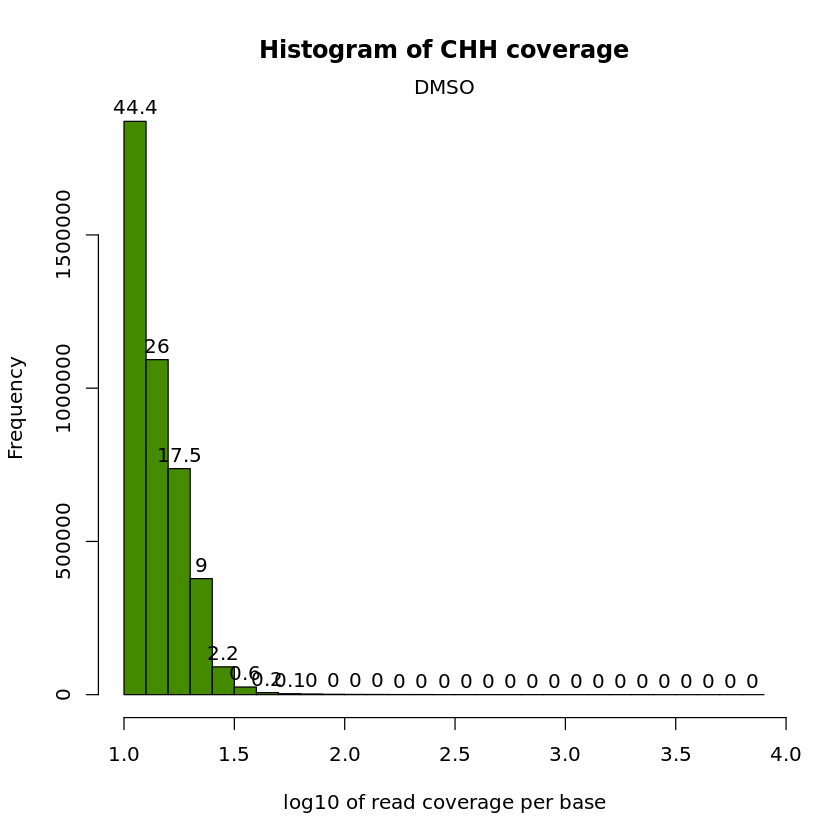

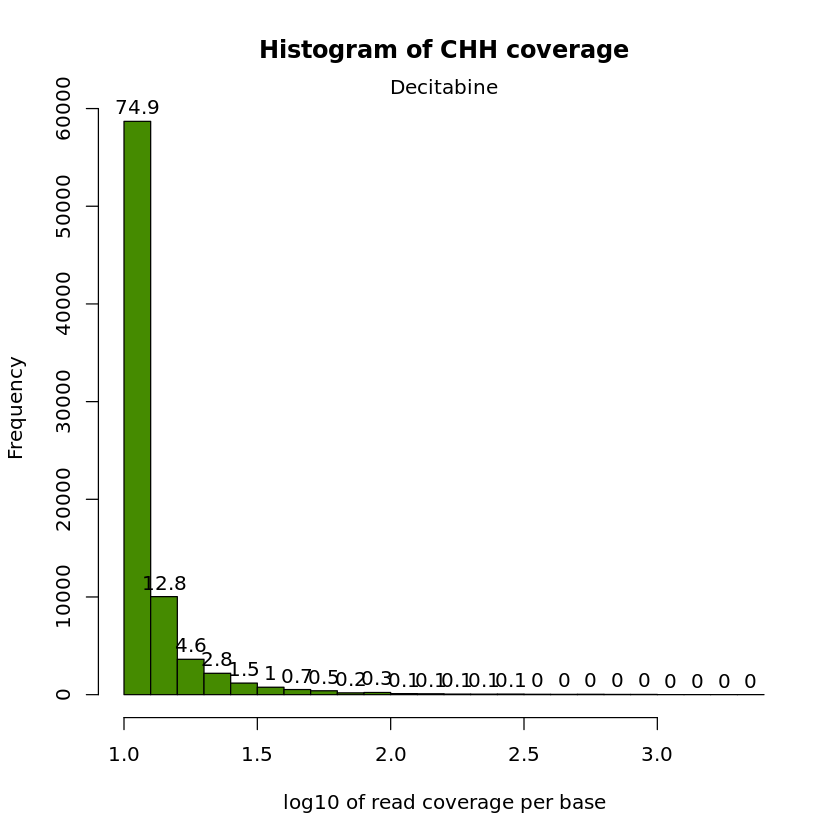

In [360]:
getCoverageStats(CHH_meth[[1]],plot=TRUE) 
getCoverageStats(CHH_meth[[2]],plot=TRUE)

#### tileMethylCounts

In [342]:
CHH_meth[[1]] %>% dim
CHH_meth[[2]] %>% dim

[1] 4211705       7

[1] 78361     7

In [124]:
CHH_tiles = tileMethylCounts(CHH_meth,win.size=500,step.size=500,cov.bases=0) %>% prepRegion

uniting...



#### calculateDiffMeth

In [127]:
CHH_tiles_diff <- calculateDiffMeth(CHH_tiles,
                            overdispersion = "MN",
                            adjust="BH")

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [128]:
CHH_tiles_diff_list = getDiffList(CHH_tiles_diff)

In [129]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CHH_tiles_diff_list$all.anot <- annotateWithGeneParts(
    target = as(CHH_tiles_diff_list$all,"GRanges"),feature = gene.obj)

[1] 85  7

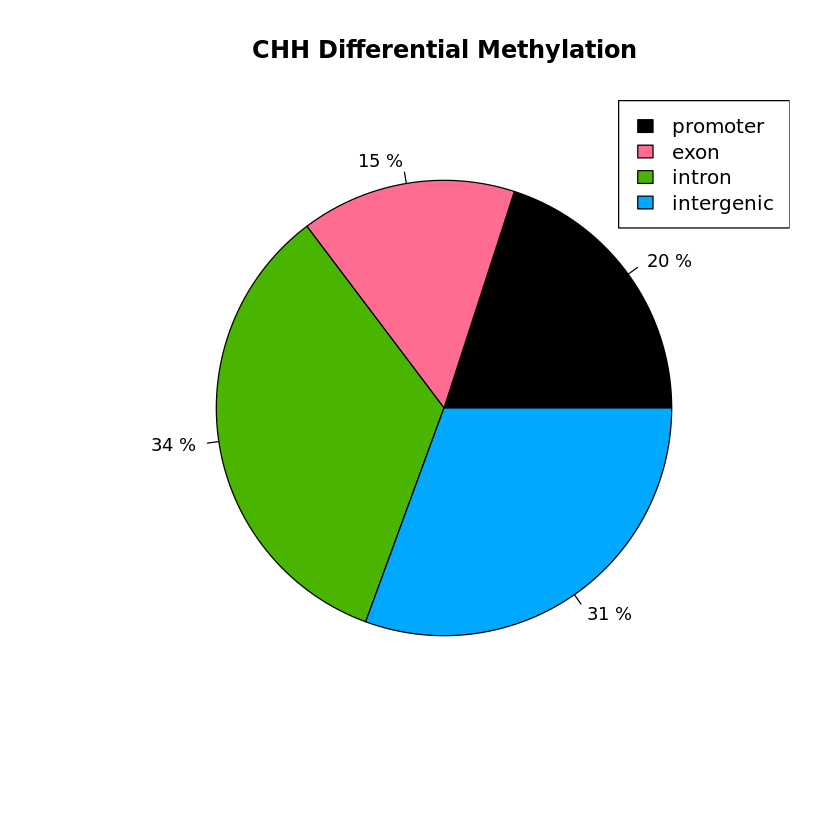

In [138]:
CHH_tiles_diff_list$all %>% dim
# This can also be summarized for all differentially methylated
plotTargetAnnotation(CHH_tiles_diff_list$all.anot, main = "CHH Differential Methylation")

Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


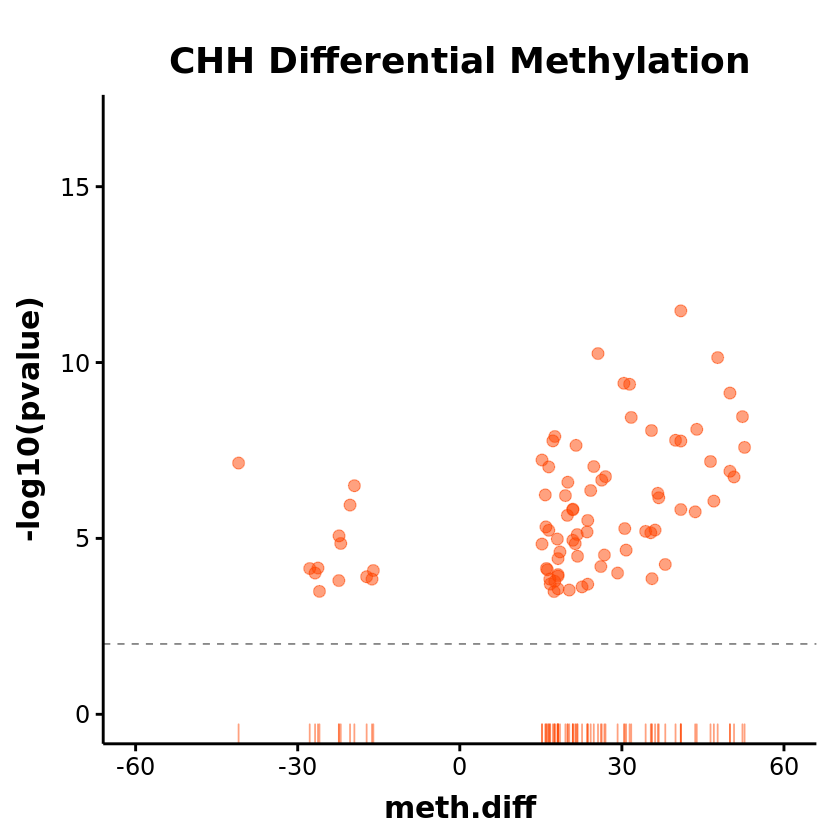

In [140]:
CHH_tiles_diff_list$all %>% data.frame %>% 
    plot_hyperhypo(5,0.01,title="CHH Differential Methylation",x_lim = c(-60,60))

___
https://mgimond.github.io/ES218/Week03b.html

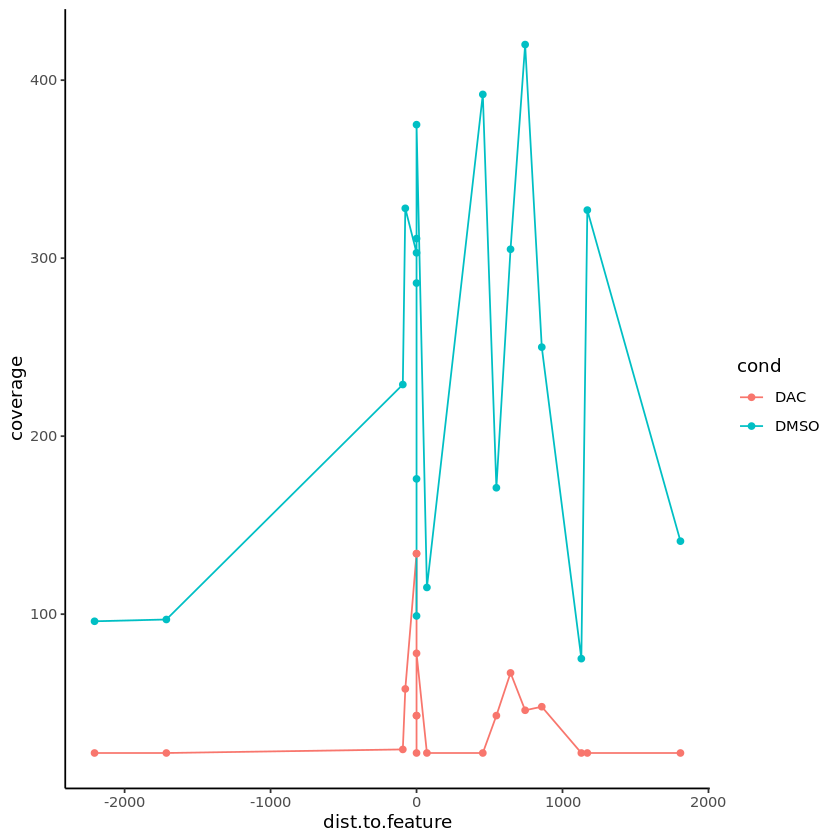

In [338]:
getPromoterDiff(
    getMethOverlap(CHH_tiles, CHH_tiles_diff_list$all), CHH_tiles_diff_list$all.anot, 
    tss.window = 2500
) %>% rename(DMSO=coverage1,DAC=coverage2) %>%
dplyr::select(DMSO,DAC,meth.diff,qvalue,dist.to.feature,feature.name,feature.strand) %>% 
rownames_to_column %>%
dplyr::filter(meth.diff > 0) %>% 
pivot_longer(cols = c(DMSO,DAC),names_to='cond',values_to = 'coverage') %>%
ggplot +
    geom_line( aes(x=dist.to.feature,y=coverage,colour=cond)) +
    geom_point(aes(x=dist.to.feature,y=coverage,colour=cond)) +
    theme_classic()

### Differentially methylated enhancers

In [628]:
CHH_tiles_diff_list$all.gr = CHH_tiles_diff_list$all %>% GRanges

In [629]:
CHH_tiles_diff_list$enh <- CHH_tiles_diff_list$all.gr[CHH_tiles_diff_list$all.gr %over% enh$enhancer] %>% data.frame
CHH_tiles_diff_list$enh

seqnames,start,end,width,strand,pvalue,qvalue,meth.diff
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>


# 

In [584]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/DNAme-DSS/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggthemes_4.2.4              ggExtra_0.10.0             
 [3] ORFik_1.14.7                GenomicAlignments_1.30.0   
 [5] Rsamtools_2.10.0            Biostrings_2.62.0          
 [7] XVector_0.34.0              GenomicFeatures_1.46.1     
 [9] AnnotationDbi_

In [585]:
date()

[1] "Sun Oct  9 02:56:23 2022"